#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
# Подключение библиотек

import warnings
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose # разделение временного ряда на тренд, сезонность и остатки
from sklearn.linear_model import Ridge # гребневая регрессия 
from sklearn.ensemble import RandomForestRegressor # случайный лес

# для разделения выборки, поиска по сетке наил. параметров, коррект. работы с временными рядами
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit 
from sklearn.metrics import mean_squared_error as mse, make_scorer # метрики, RMSE = MSE ** 0.5

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Настройки
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Константы

STATE = 123 # значение для параметра random_state

In [3]:
# Функция для визуализации распределений, 
# а также результатов разложения временного ряда на три составляющие: тренд, сезонность и остаток

def draw_graph(data, title, bins=100, rolling_size=10, dec=False):
    
    fg = plt.figure(figsize=(19, 18), constrained_layout=True)
    gs = fg.add_gridspec(2, 2)
    
    if dec == False:
        
        fig_ax_1 = fg.add_subplot(gs[0, :])
        sns.lineplot(data=data, x=data.index, y='num_orders', 
                 label='num_orders', color='#957B8D')
        sns.lineplot(data=data, x=data.index, y=data['num_orders'].rolling(rolling_size).mean(), 
                 label='mean', color='#6495ED')
        sns.lineplot(data=data, x=data.index, y=data['num_orders'].rolling(rolling_size).std(), 
                 label='std', color='#FFB02E')
        plt.grid(linewidth = 0.5, linestyle = '--')
        plt.title(title, fontdict={'fontsize': 14, 'fontfamily': 'cursive'})
        
        fig_ax_2 = fg.add_subplot(gs[1, 0])
        sns.histplot(data=data, x='num_orders', kde=True, bins=bins, color='cadetblue')
        plt.grid(linewidth = 0.5, linestyle = '--')
        plt.title('Feature "num_orders" distribution', fontdict={'fontsize': 14, 'fontfamily': 'cursive'})
        plt.ylabel('count / density')
        
        fig_ax_3 = fg.add_subplot(gs[1, 1])
        sns.boxplot(data=data, x='num_orders', color='#FFDAB9')
        plt.grid(linewidth = 0.5, linestyle = '--')
        plt.title('Boxplot for feature "num_orders"', fontdict={'fontsize': 14, 'fontfamily': 'cursive'})
        
        plt.show()
    else:
                
        fig_ax_1 = fg.add_subplot(gs[0, 0])
        sns.lineplot(data=data.trend.to_frame(), x=data.trend.index, y=data.trend, color='#957B8D')
        plt.grid(linewidth = 0.5, linestyle = '--')
        plt.title('Trend chart for the period - ' + title, fontdict={'fontsize': 14, 'fontfamily': 'cursive'})
        
        fig_ax_1 = fg.add_subplot(gs[0, 1])
        sns.lineplot(data=data.seasonal.to_frame(), x=data.seasonal.index, y=data.seasonal, color='#957B8D')
        plt.grid(linewidth = 0.5, linestyle = '--')
        plt.title('Seasonal chart for the period - ' + title, fontdict={'fontsize': 14, 'fontfamily': 'cursive'})       
        
        fig_ax_3 = fg.add_subplot(gs[1, :])
        sns.lineplot(data=data.resid.to_frame(), x=data.resid.index, y=data.resid, color='#957B8D')
        plt.grid(linewidth = 0.5, linestyle = '--')
        plt.title('Resid chart for the period - ' + title, fontdict={'fontsize': 14, 'fontfamily': 'cursive'})
        
        plt.show()

In [4]:
# Функция для вычисления метрики качества модели (RMSE)

def rmse_score(target, predictions):
    return mse(target, predictions) ** 0.5

In [5]:
# Функция для подбора наилучших гиперпараметров модели 
# Обучает модель на обучающем наборе данных, возвращает лучшие: модель, параметры и метрику качества (RMSE)

def best_model_params(model, params, features_train, target_train):
    
    gs_model = GridSearchCV(model, param_grid=params, 
                            scoring=make_scorer(rmse_score, greater_is_better=False),
                            cv=TimeSeriesSplit(n_splits=3), n_jobs=-1)
    gs_model.fit(features_train, target_train)
    
    best_model = gs_model.best_estimator_
    best_params = gs_model.best_params_
    best_score = (-1) * gs_model.best_score_
    
    return best_model, best_params, best_score

## Загрузка и подготовка данных

In [6]:
# Загрузка данных

try:
    df = pd.read_csv('taxi.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [7]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [8]:
# Просмотр основной информации, описательных статистик 

display(df.info(), df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Загрузим наши данные ещё раз, на этот раз учтём, что необходимо: изменить тип данных `datetime` с object на datetime64, перевести дату в индекс:

In [9]:
# Загрузка данных (повторная)

try:
    #df = pd.read_csv('taxi.csv', parse_dates=['datetime'], index_col='datetime')
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    #df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

In [10]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [11]:
# Проверка наличия пропусков

df.isna().sum().sort_values(ascending=False)

num_orders    0
dtype: int64

In [12]:
# Определяем период, за который представлены данные 
# (представлены данные с марта по август)

display(df.idxmin(), df.idxmax())

num_orders   2018-03-01 05:20:00
dtype: datetime64[ns]

num_orders   2018-08-13 02:20:00
dtype: datetime64[ns]

In [13]:
# Сортируем данные по индексу, проверяем, в хронологическом ли порядке расположены даты и время

df = df.sort_index()

if df.index.is_monotonic_increasing:
    print('Данные расположены в хронологическом порядке')
else:
    print('Что-то не так с порядком расположения данных')

Данные расположены в хронологическом порядке


In [14]:
# Ресемплирование данных по одному часу

df_resampling = df.resample('1H').sum()

#### Вывод:

- Данные загружены, пропуски в даннах отстутвуют;

- Определен период, за который предоставлены данные;

- Произведено ресемплирование данных по одному часу.

## Анализ

In [15]:
# Смотрим на описательные статистики

df_resampling.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


- Построим графики для ресемплированных данных (за весь период, за месяц и за три дня):

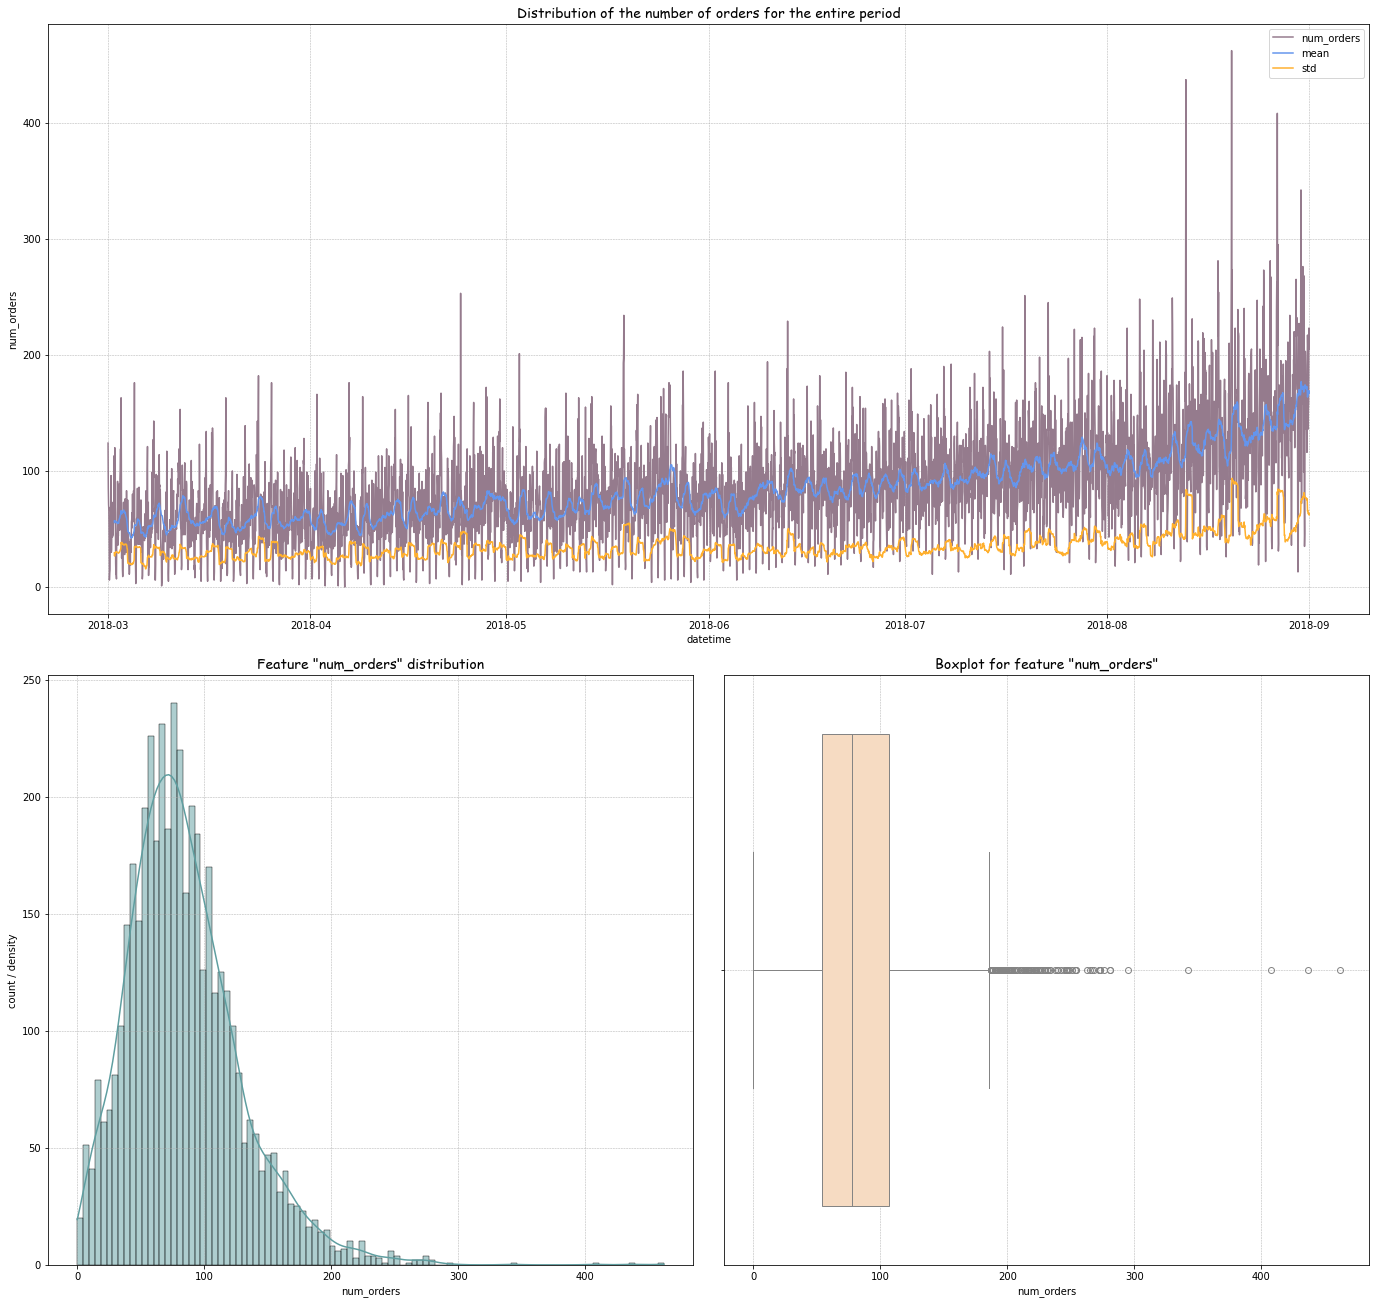

In [16]:
# весь период
draw_graph(df_resampling, 'Distribution of the number of orders for the entire period', rolling_size=24)

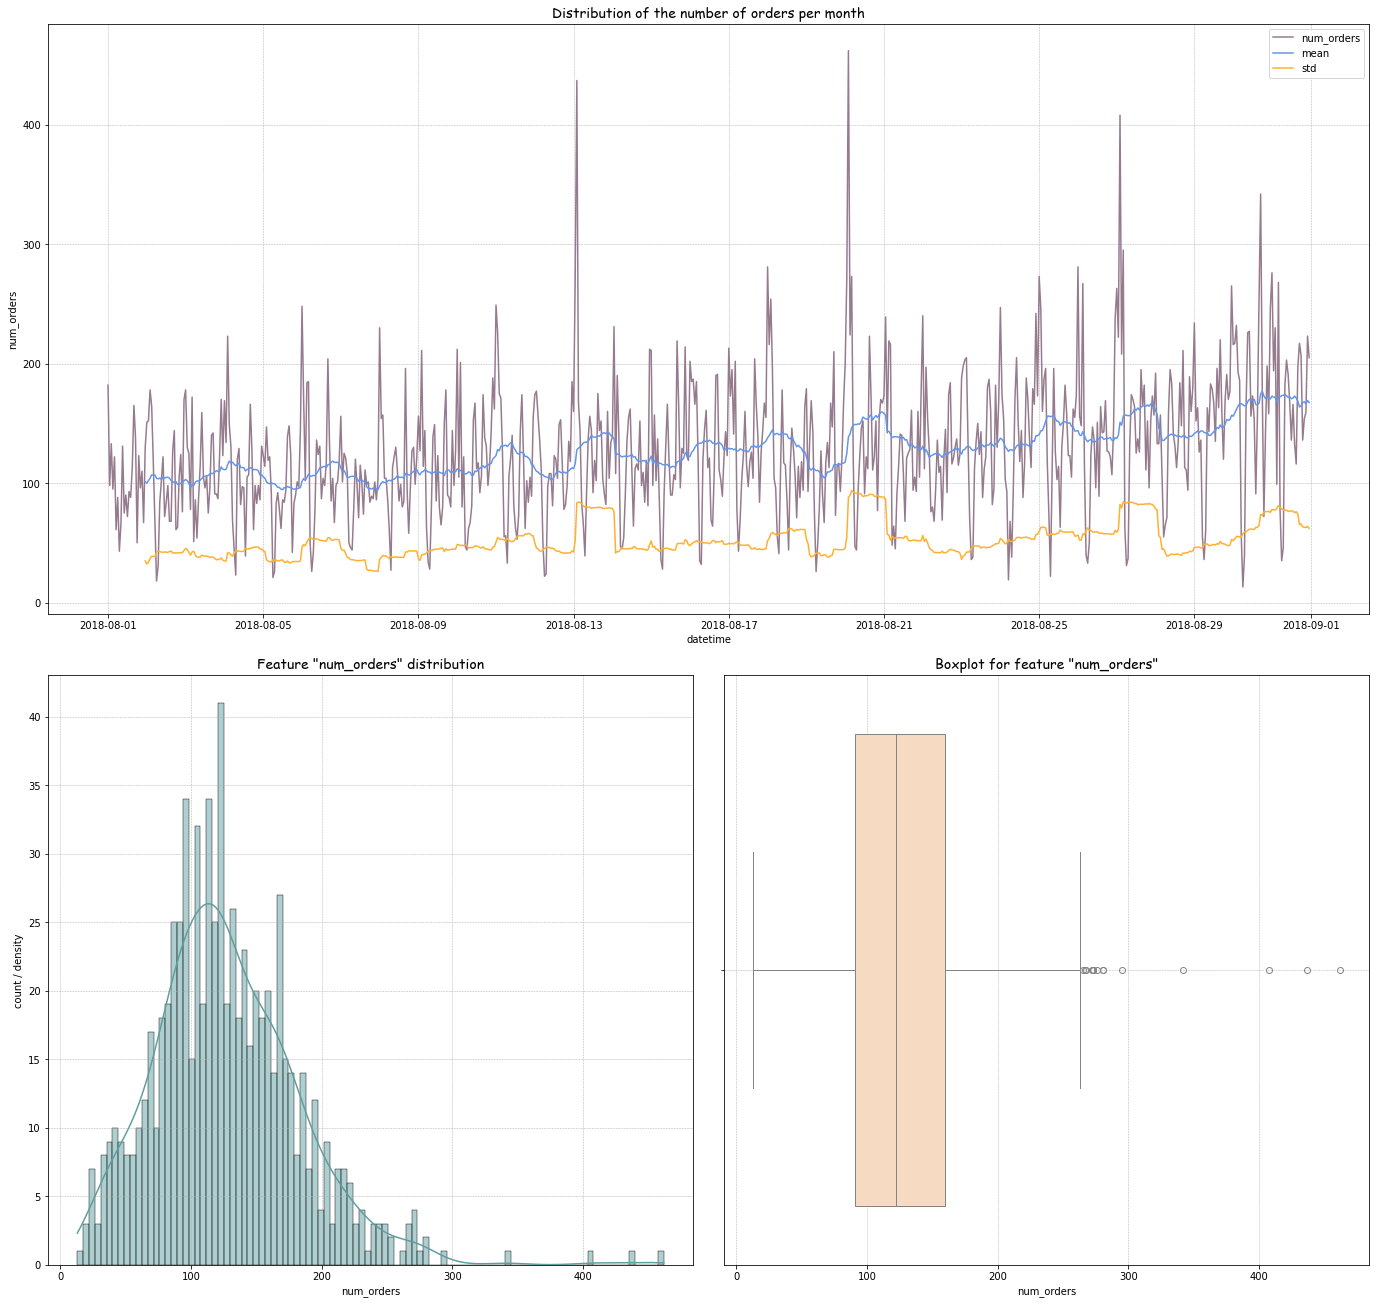

In [17]:
# август 2018 г.
draw_graph(df_resampling['2018-08':'2018-08'], 'Distribution of the number of orders per month', rolling_size=24)

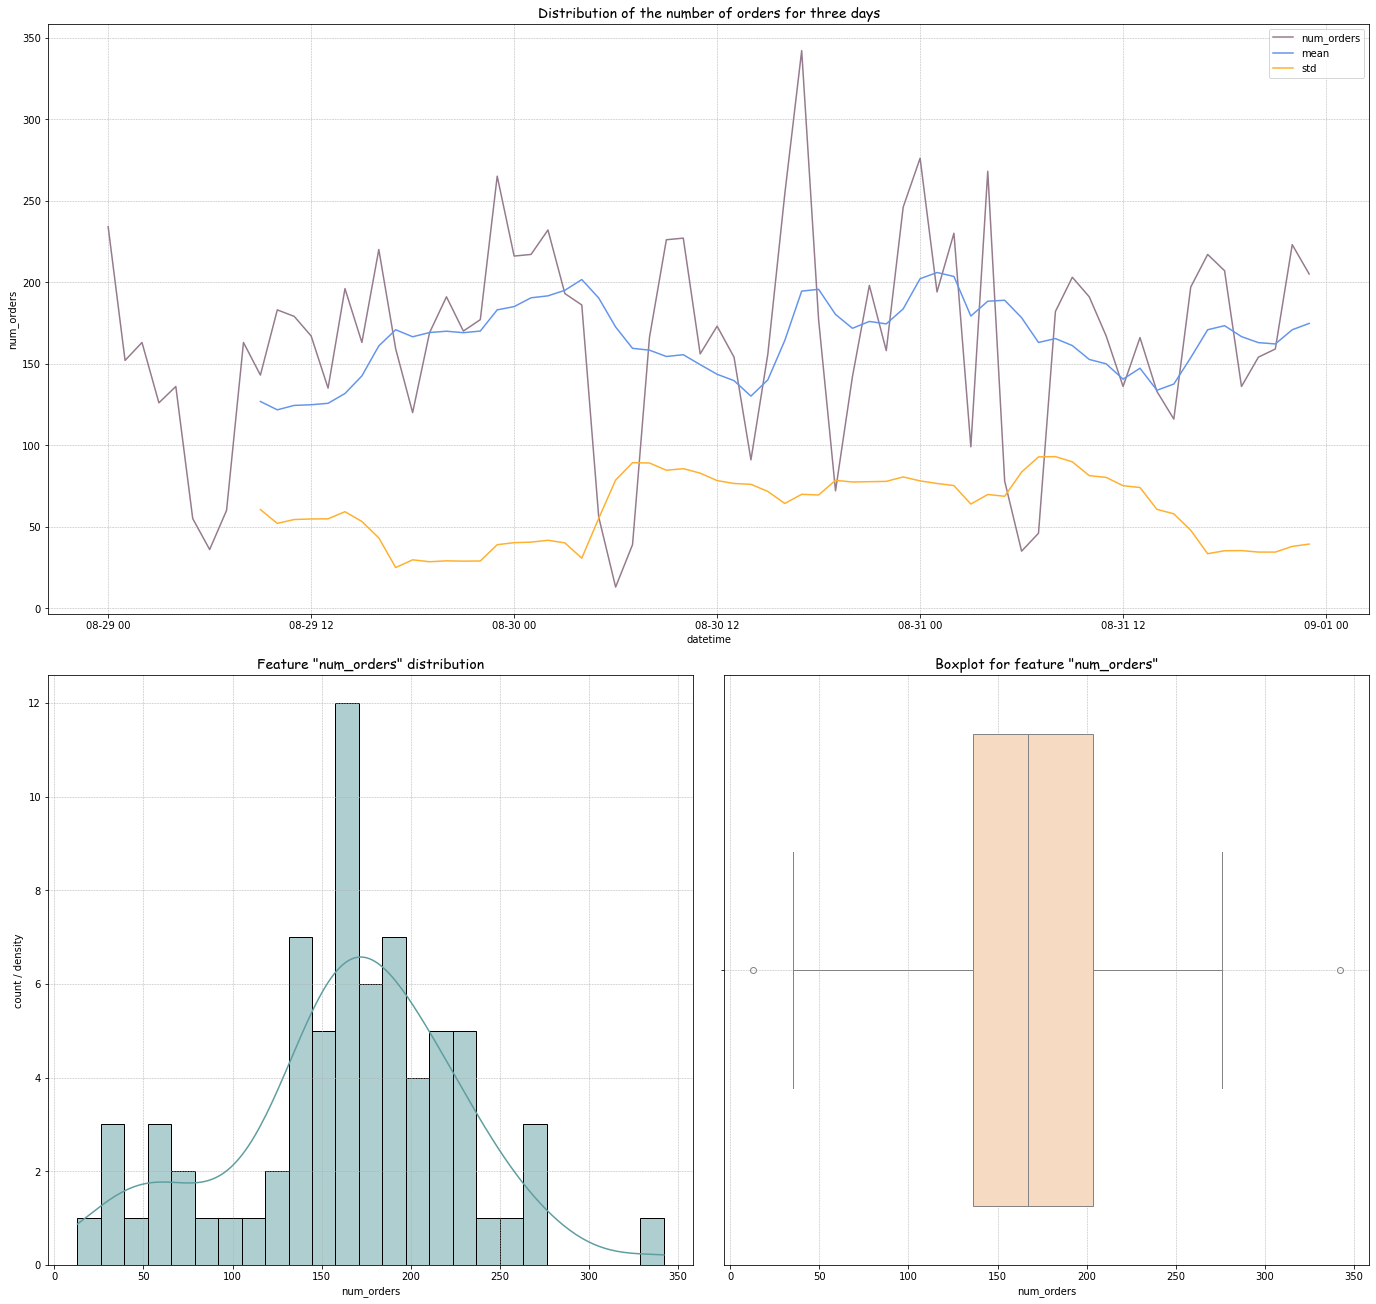

In [18]:
# три крайних дня августа 2018 г.
draw_graph(df_resampling['2018-08-29':'2018-08-31'], 'Distribution of the number of orders for three days', bins=25)

Можно видеть, что среднее значение и стандартное отклонение количества заказов такси незначительно, но всё же увеличивается со временем, следовательно, временной ряд не является стационарным. 

За имеющийся период данных среднее кол-во заказов в час составляет около 84 заказов. Сильные "всплески" количества (более трёхста шт. в час) наблюдаются редко и исключительно в августе, в остальные месяцы распределения приблизительно равномерны (в целом к выбросам можно отнести значения кол-ва заказов, превышающие величину в 200 шт.).

- Изучим тренд, сезонность, "хвосты":

In [19]:
decomp_df = seasonal_decompose(df_resampling) # за весь срок

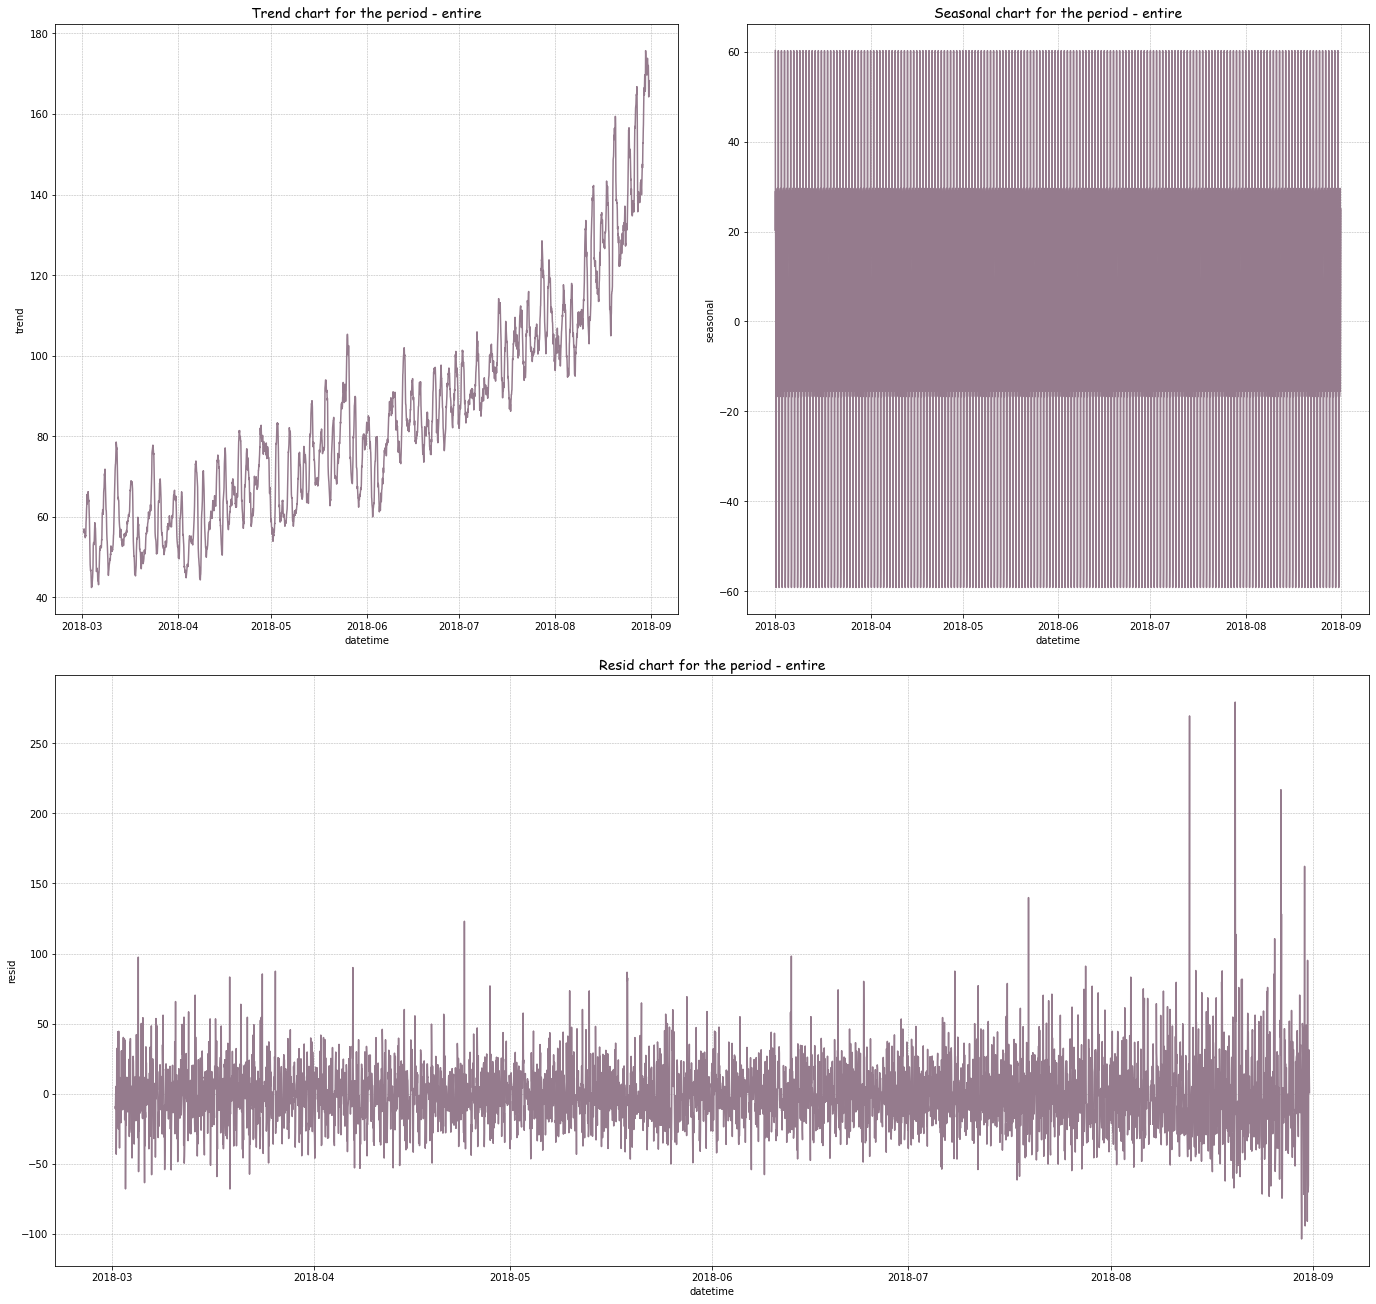

In [20]:
draw_graph(decomp_df, 'entire', dec=True)

Можно наблюдать возрастающий тренд, тогда как в данном масштабе о сезонной составляющей сложно что-то сказать. Рассмотрим далее срез данных за месяц и три последних дня:

In [21]:
decomp_df = seasonal_decompose(df_resampling['2018-08':'2018-08']) # за месяц

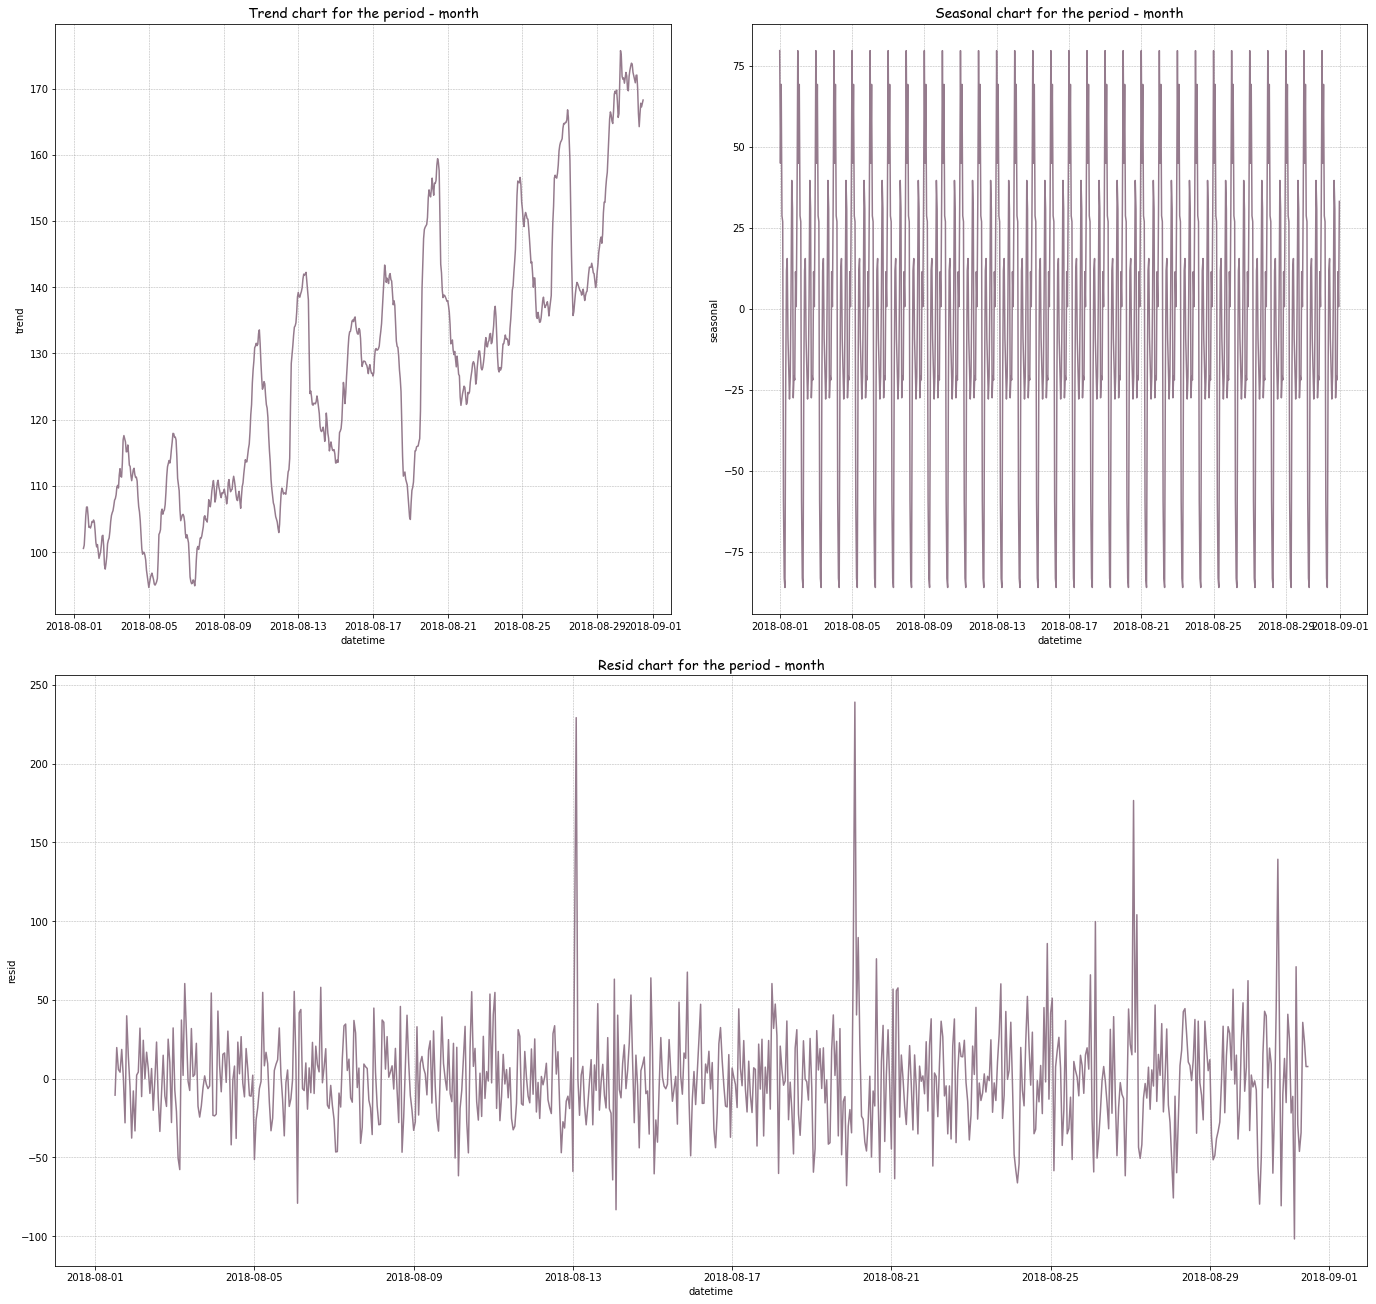

In [22]:
draw_graph(decomp_df, 'month', dec=True)

In [23]:
decomp_df = seasonal_decompose(df_resampling['2018-08-29':'2018-08-31']) # за три дня

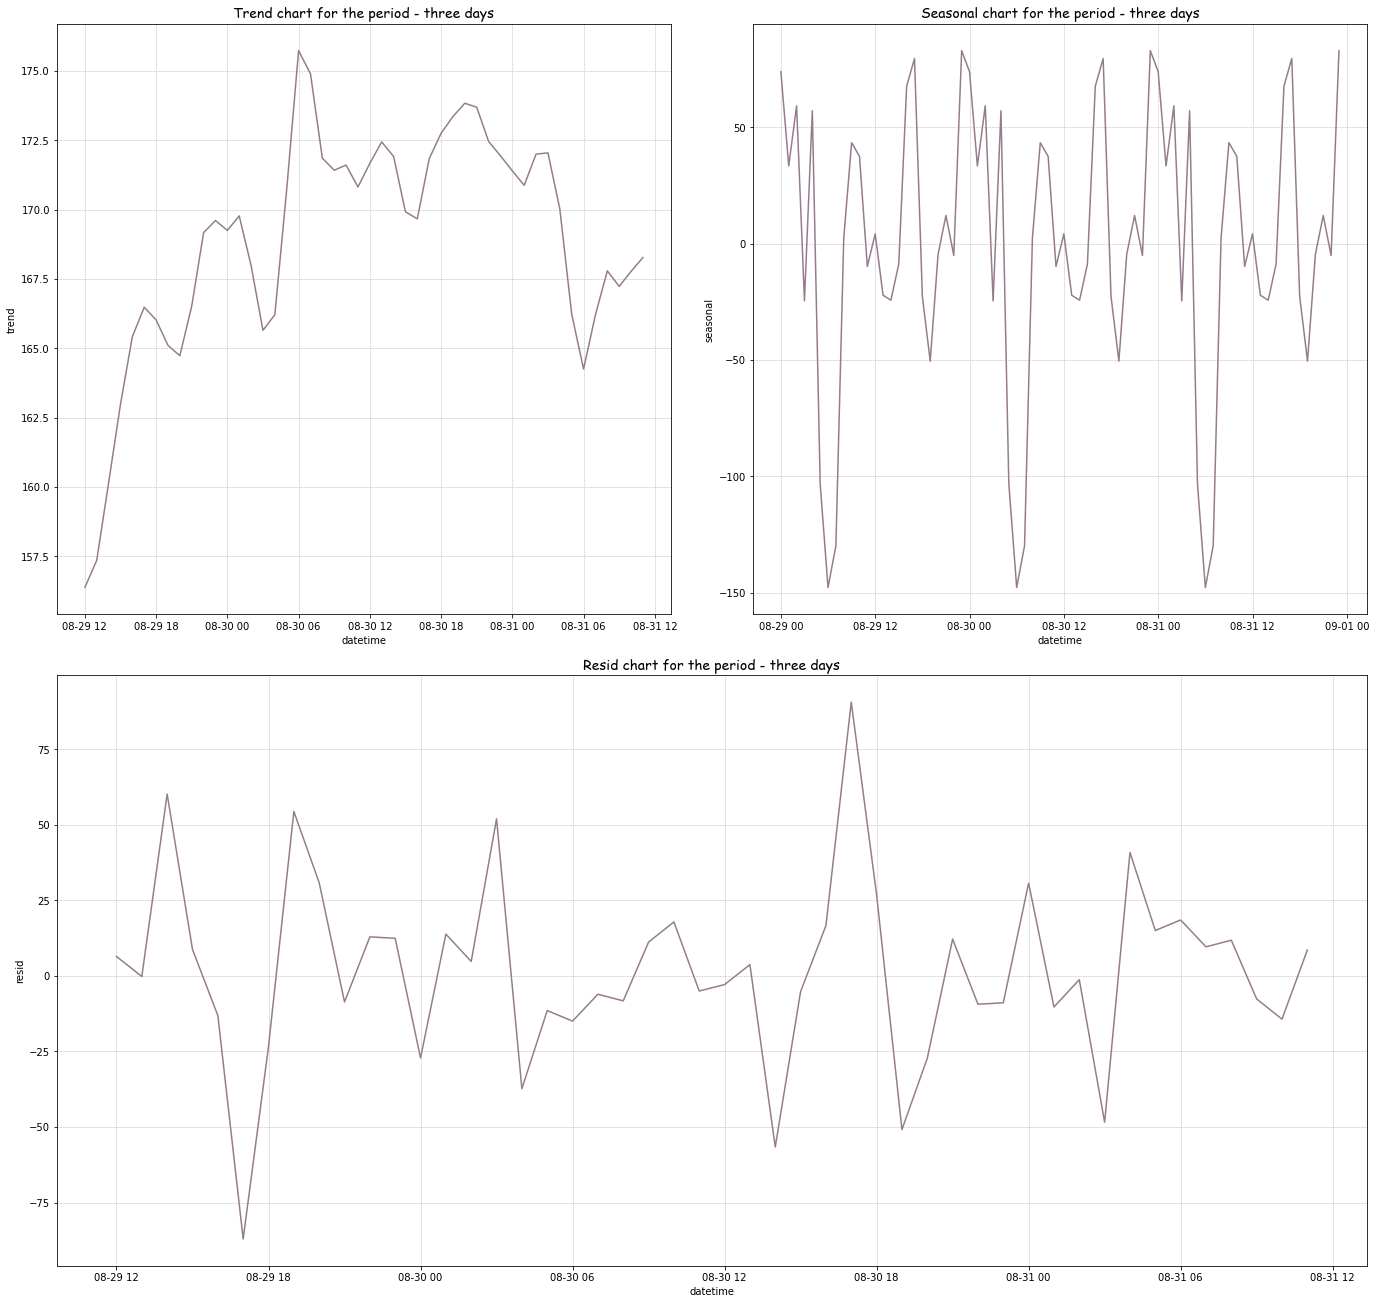

In [24]:
draw_graph(decomp_df, 'three days', dec=True)

Наблюдаем падение количества заказов в ночное время (с 12 ночи до минимального в 6 утра), рост в утренние часы (пиковые максимумы около 9-10 утра). Далее идет снижение, с последующим достижением минимальных пиковых значений в районе 17-18 часов и рост до максимальных пиковых значений в районе 12 ночи.  

#### Вывод:

- Проведён анализ данных;

- Наблюдается тенденция тренда к возрастанию, как за весь срок наблюдения, так и в рамках недели (кол-во заказов растёт к концу недели, и идёт на спад в выходные);

- Установлено наличие сезонности в разрезе суток;

## Обучение

В качестве моделей рассмотрим: вариацию линейной модели, модель случайного леса и градиентный бустинг:

- `RidgeRegression`

- `RandomForestRegressor`

- `CatBoostRegressor`

- `LGBMRegressor`

Создаём новые признаки: час, день недели, отстающие значения и скользящее среднее.

In [25]:
def make_features(data, max_lag, rolling_mean_size):
    df_features = data.copy()
    df_features['hour'] = df_features.index.hour
    df_features['day_of_week'] = df_features.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_features['lag_{}'.format(lag)] = df_features['num_orders'].shift(lag)
    
    df_features['rolling_mean'] = df_features['num_orders'].shift().rolling(rolling_mean_size).mean()
    df_features.dropna(inplace=True)

    return df_features

In [26]:
df = make_features(df_resampling, 24, 10)
df.head()

,num_orders,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,61.7
2018-03-02 01:00:00,120,1,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,65.9
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,71.3
2018-03-02 03:00:00,64,3,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,74.5
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,76.5


In [27]:
# Сохраним признаки и целевой признак (далее ц.п.) в отдельных переменных
# Введём обозначения: X - признаки, y - ц.п. (по аналогии с обозначениями выборок)

X = df.drop(columns='num_orders') # извлекаем признаки

y = df['num_orders'] # извлекаем целевой признак

Разобьём наши данные на тренировочную и тестовую выборки:

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=STATE, shuffle=False)

In [29]:
# Проверка

display(X_train.shape, X_test.shape)
display(y_train.shape, y_test.shape)

(3952, 27)

(440, 27)

(3952,)

(440,)

#### Гребневая регрессия (Ridge)

In [30]:
rg_model = Ridge(random_state=STATE)
rg_params = {'solver': ['svd', 'lsqr']}

In [31]:
rg, rg_best_params, rg_score = best_model_params(rg_model, rg_params, X_train, y_train)

In [32]:
print('Параметры "лучшей" модели ', rg_best_params)
print('Значение метрики качества: ', round(rg_score, 2))

Параметры "лучшей" модели  {'solver': 'svd'}
Значение метрики качества:  27.77


#### Случайный лес (RandomForestRegressor)

In [33]:
rfr_model = RandomForestRegressor(random_state=STATE)
rfr_params = {'n_estimators': np.arange(100, 501, 200), 
              'max_depth': np.arange(15, 18)}

In [34]:
rfr, rfr_best_params, rfr_score = best_model_params(rfr_model, rfr_params, X_train, y_train)

In [35]:
print('Параметры "лучшей" модели ', rfr_best_params)
print('Значение метрики качества: ', round(rfr_score, 2))

Параметры "лучшей" модели  {'max_depth': 15, 'n_estimators': 500}
Значение метрики качества:  26.74


#### Градиентный бустинг (CatBoostRegressor)

In [36]:
cbr_model = CatBoostRegressor(random_state=STATE, silent=True)
cbr_params = {'learning_rate': [0.1], 
              'iterations': [10, 50, 75], 
              'max_depth': [10, 20]}

In [37]:
cbr, cbr_best_params, cbr_score = best_model_params(cbr_model, cbr_params, X_train, y_train)

In [38]:
print('Параметры "лучшей" модели ', cbr_best_params)
print('Значение метрики качества: ', round(cbr_score, 2))

Параметры "лучшей" модели  {'iterations': 75, 'learning_rate': 0.1, 'max_depth': 10}
Значение метрики качества:  27.89


#### Градиентный бустинг (LGBMRegressor)

In [39]:
lgbm_model = LGBMRegressor(random_state=STATE)
lgbm_params = {'n_estimators': np.arange(10, 91, 20), 
               'max_depth': [15, 30], 
               'num_leaves': [5, 10, 15], 
               'learning_rate': [0.1]}

In [40]:
lgbm, lgbm_best_params, lgbm_score = best_model_params(lgbm_model, lgbm_params, X_train, y_train)

In [41]:
print('Параметры "лучшей" модели ', lgbm_best_params)
print('Значение метрики качества: ', round(lgbm_score, 2))

Параметры "лучшей" модели  {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 90, 'num_leaves': 10}
Значение метрики качества:  26.32


Сгруппируем полученные значения метрик построенных моделей в следующую сравнительную таблицу:

In [42]:
results = pd.DataFrame({'RMSE value': [rg_score, rfr_score, cbr_score, lgbm_score]},
                       index=['Ridge','RandomForestRegressor','CatBoostRegressor', 'LGBMRegressor'])
results.sort_values(by='RMSE value')

,RMSE value
LGBMRegressor,26.317475
RandomForestRegressor,26.737216
Ridge,27.773191
CatBoostRegressor,27.893216


## Тестирование

В качестве "лучшей" модели, с учётом минимального значения метрики, полученного на тренировочных данных, выбираем модель `LGBMRegressor`, получим предсказания и значение `RMSE` на тестовых данных:

In [43]:
target_pred = lgbm.predict(X_test)
rmse_score(y_test, target_pred)

41.32783278460196

Цель достигнута, на тестовых данных значение метрики `RMSE` составляет 41.33, что меньше установленного порога. 

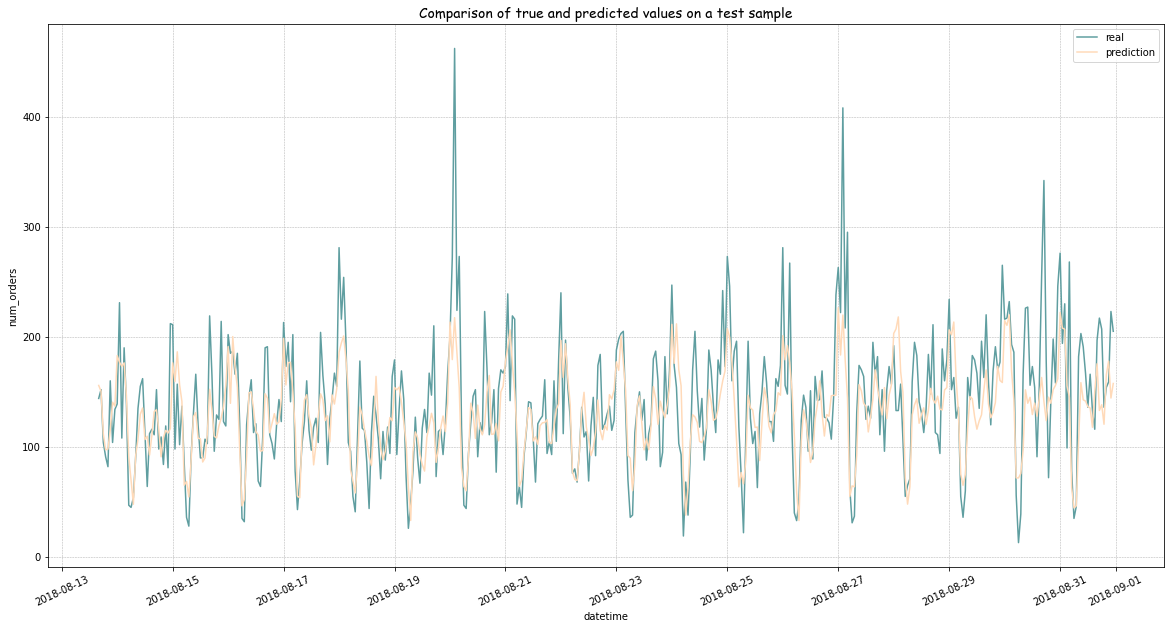

In [44]:
# Строим график временных рядов, на которых отображаем
# предсказанные значения лучшей модели и реальные тестовые значения целевой переменной

plt.figure(figsize=(20, 10))

sns.lineplot(x=y_test.index, y=y_test, label='real', color='cadetblue')
sns.lineplot(x=y_test.index, y=target_pred, label='prediction', color='#FFDAB9')

plt.xticks(rotation=25)
plt.grid(linewidth = 0.5, linestyle = '--')
plt.title('Comparison of true and predicted values on a test sample', fontdict={'fontsize': 14, 'fontfamily': 'cursive'})

plt.show()

#### Вывод:

В ходе исследования . Построены и обучены модели: RidgeRegression, RandomForestRegressor, CatBoostRegressor и LGBMRegressor. Лучшее значение метрики получено для модели градиентного бустинга (LGBMRegressor) c гиперпараметрами:

- `learning_rate`: 0.1

- `max_depth`: 15

- `n_estimators`: 90

- `num_leaves`: 10

Значение метрики выбранной модели на тестовых данных не превосходит 48, таким обрвзом, данную модель можно рекомендовать для прогноза.